# Machine Learning Tutorial - Parameter Tuning, Model Selection

In [127]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns
from operator import itemgetter

import numpy as np
from scipy.stats import randint as sp_randint

from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize, scale
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets, metrics, preprocessing
from time import time

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
import hyperopt.pyll.stochastic

[]

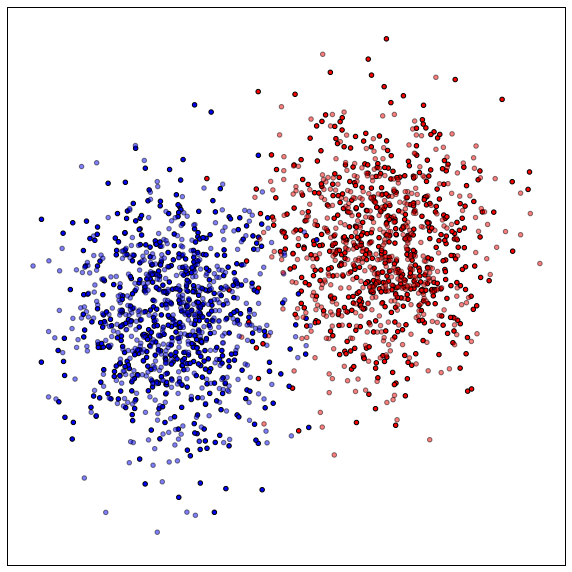

In [65]:
# make dataset
n1, n2 = 1000, 1000

mean = [0,0]
cov = [[1,0],[0,1]]
X1 = np.random.multivariate_normal(mean,cov,n1)
y1 = np.repeat(1,n1)

mean = [4,1]
cov = [[1,0],[0,1]]
X2 = np.random.multivariate_normal(mean,cov,n2)
y2 = np.repeat(0,n2)

X = np.r_[X1, X2]
y = np.r_[y1, y2]

# split dataset into two datasets by random sampling
# classifier will learn on the training dataset
# classifier will predict on the testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
h = .02
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
f, ax = plt.subplots(1, figsize=(10,10))
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.5)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

## Random Forests using Random Search and Grid Search

In [63]:
clf = RandomForestClassifier(n_estimators=20)

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 2),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 2],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

RandomizedSearchCV took 2.15 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.979 (std: 0.007)
Parameters: {'bootstrap': True, 'min_samples_leaf': 4, 'min_samples_split': 1, 'criterion': 'gini', 'max_features': 1, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.978 (std: 0.008)
Parameters: {'bootstrap': True, 'min_samples_leaf': 7, 'min_samples_split': 2, 'criterion': 'entropy', 'max_features': 1, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.978 (std: 0.006)
Parameters: {'bootstrap': True, 'min_samples_leaf': 4, 'min_samples_split': 1, 'criterion': 'entropy', 'max_features': 1, 'max_depth': 3}

GridSearchCV took 16.85 seconds for 144 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.980 (std: 0.006)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'min_samples_split': 1, 'criterion': 'gini', 'max_features': 1, 'max_depth': 3}

Model with rank: 2
Mean validation score: 0.980 (std: 0

## Random Forest using HyperOpt

In [66]:
def hyperopt_train_test(params):
    #clf = KNeighborsClassifier(n_neighbors=params['k'])
    clf = RandomForestClassifier(n_estimators=params['n_estimators'],max_depth=params['max_depth'],
                                max_features=params['max_features'], criterion=params['criterion'])
    #clf = DecisionTreeClassifier(max_depth=params['max_depth'], max_features=params['max_features'])
    return -cross_val_score(clf, X, y, cv=10).mean()
    
space4knn = {
    'k': 10 + hp.randint('k', 200)
}

space4dt = {
    'max_depth': hp.choice('max_depth', range(1,10)),
    'max_features': hp.choice('max_features', range(1,3))
}

space4rf = {'n_estimators': hp.choice('n_estimators', range(1,20)),
            'max_depth': hp.choice('max_depth', range(1,10)),
            'max_features': hp.choice('max_features', range(1,3)),
            'criterion': hp.choice('criterion', ["gini", "entropy"])}

def f(params):
    #print params
    error = hyperopt_train_test(params)
    #print error, params
    return {'loss': error, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=100, trials=trials)
print 'best:'
print best
print ''
for trial in trials.trials[-5:]:
    print trial
# {'max_features': 0, 'n_estimators': 13, 'criterion': 0, 'max_depth': 2}
# {'max_features': 0, 'n_estimators': 13, 'criterion': 0, 'max_depth': 2}


best:
{'max_features': 0, 'n_estimators': 13, 'criterion': 0, 'max_depth': 2}

{'refresh_time': None, 'book_time': None, 'misc': {'tid': 95, 'idxs': {'max_features': [95], 'n_estimators': [95], 'criterion': [95], 'max_depth': [95]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'max_features': [1], 'n_estimators': [16], 'criterion': [1], 'max_depth': [2]}, 'workdir': None}, 'state': 2, 'tid': 95, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': -0.976}, 'owner': None, 'spec': None}
{'refresh_time': None, 'book_time': None, 'misc': {'tid': 96, 'idxs': {'max_features': [96], 'n_estimators': [96], 'criterion': [96], 'max_depth': [96]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'max_features': [1], 'n_estimators': [17], 'criterion': [1], 'max_depth': [2]}, 'workdir': None}, 'state': 2, 'tid': 96, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': -0.9774999999999998}, 'owner': None, 'spec': None}
{'refresh_time': None, 'book_time'

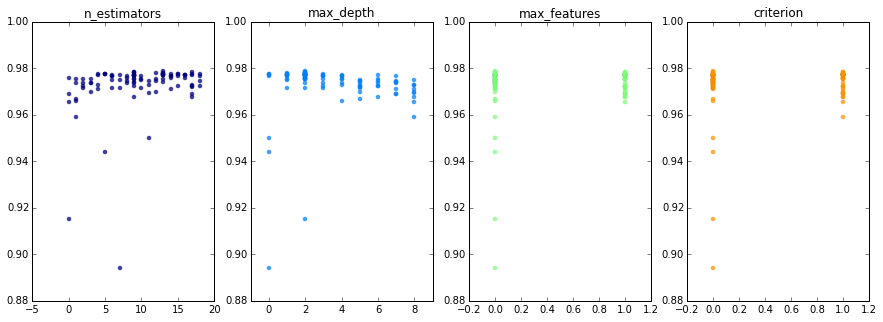

In [67]:
#parameters = ['max_depth', 'max_features']
parameters = ['k', '']
parameters = ['n_estimators', 'max_depth', 'max_features', 'criterion']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)


## Confusion Matrix

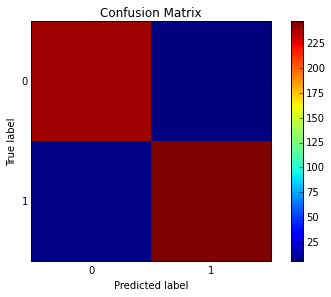

In [65]:
# best params: {'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 1, 
#  'min_samples_split': 3, 'criterion': 'entropy', 'max_features': 2, 'max_depth': None}
#{'bootstrap': True, 'min_samples_leaf': 4, 'min_samples_split': 1, 
# 'criterion': 'gini', 'max_features': 1, 'max_depth': None}
clf = RandomForestClassifier(n_estimators=1,
                             max_depth=None,
                             max_features=2,
                             min_samples_split=3,
                             min_samples_leaf=10,
                             bootstrap=True,
                             criterion='entropy')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
y_pred = clf.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, range(2))
plt.yticks(tick_marks, range(2))
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


# Parameter Tuning in Python Using Hyperopt
This post will cover a few things needed to quickly implement a fast, principled method for parameter tuning. There are two common methods of parameter tuning: grid search and random search. Each have their pros and cons. Grid search is slow but effective at searching the whole search space, while random search is fast, but could miss important ranges in the search space. Luckily, a third option exists: bayesian optimization. In this post, we will focus on one implementation of bayesian optimization, a Python module called `hyperopt`. 

Using bayesian optimization for parameter tuning allows us to obtain the best parameters for a given model, e.g., logistic regression. This also allows us to perform optimal model selection. Typically, a machine learning engineer or data scientist will perform some form of manual parameter tuning (grid search or random search) for a few models--like decision tree, support vector machine, and k nearest neighbors--then compare the accuracy scores and select the best one for use. This method has the possiblity of comparing sub-optimal models. Maybe the data scientist found the optimal parameters for the decision tree, but missed the optimal parameters for SVM. This means their model comparison was flawed. K nearest neighbors may beat SVM every time if the SVM parameters are poorly tuned. Bayesian optimization allow the data scientist to find the *best* parameters for all models, and therefore compare the best models. This results in better model selection, because you are comparing the *best* k nearest neighbors to the *best* decision tree. Only in this way can you do model selection with high confidence, assured that the actual best model is selected and used. 

Topics covered are in this post are 
1. objective functions
2. search spaces
3. storing evaluation trials
4. visualization
5. full example on a classic datasetiris = datasets.load_iris()
X_original = iris.data
y_original = iris.target

To use the code below, you must install `hyperopt` and `pymongo`. 

# 1. Objective Functions - A Motivating Example
Suppose you have a function defined over some range, and you want to minimize it--that is, you want to find the input value(s) that result in the lowest output value. 
The example below finds the value of `x` that minimizes a linear function `y(x) = x`. 
```
from hyperopt import fmin, tpe, hp
best = fmin(fn=lambda x: x,
    space=hp.uniform('x', 0, 1),
    algo=tpe.suggest,
    max_evals=100)
print best
```
Let's break this down. 

The function `fmin` first takes a function to minimize, denoted `fn`, which we here specify with an anonymous function `lambda x: x`. This function could be any valid value-returning function, such as mean absolute error in regression.  

The next parameter specifies the search space, and in this example it is the continuous range of numbers between 0 and 1, specified by `hp.uniform('x', 0, 1)`. `hp.uniform` is a built-in `hyperopt` function that takes three parameters: the name, `x`, and the lower and upper bound of the range, `0` and `1`. 

The parameter `algo` takes a search algorithm, in this case `tpe` which stands for *tree of Parzen estimators*. This topic is beyond the scope of this blog post, but the mathochistic reader may peruse [this](http://arxiv.org/abs/1209.5111) for details. `algo` can also be set to `hyperopt.random`, but we do not cover that here as it is widely known search strategy. However, in a future post, we can 

Finally, we specify the maximum number of evaluations `max_evals` the `fmin` function will perform. 
`fmin` returns a python dictionary of values. 

An example of the output for the function above is `{'x': 0.000269455723739237}`. 

Here is the plot of the function. The red dot is the point we are trying to find. 

![Example 1](./images/ex1.png)

## 1.2 More Complicated Examples
Here is a more complicated objective function: `lambda x: (x-1)**2`. This time we are trying to minimize a quadratic equation `y(x) = (x-1)**2`. So we alter the search space to include what we know to be the optimal value (`x=1`) plus some sub-optimal ranges on either side: `hp.uniform('x', -2, 2)`. Now we have 
```
best = fmin(fn=lambda x: (x-1)**2,
    space=hp.uniform('x', -2, 2),
    algo=tpe.suggest,
    max_evals=100)
print best
```
The output should look something like this:
```
{'x': 0.997369045274755}
```
Here is the plot. 
![Example 2](./images/ex2.png)
Instead of minimizing an objective function, maybe we want to maximize it. To to this we need only return the negative of the function. For example, we could have a function `y(x) = -(x**2)`:
![Example 3](./images/ex3.png)
How could we go about solving this? We just take the objective function `lambda x: -(x**2)` and return the negative, giving `lambda x: -1*-(x**2)` or just `lambda x: (x**2)`. 

Here is one similar to example 1, but instead of minimizing, we are trying to maximize. 
![Example 4](./images/ex4.png)

Here is a function with many (infinitely many given an infinite range) local minima, which we are also trying to maximize:
![Example 5](./images/ex5.png)

# 2. Search Spaces
`hyperopt` includes a few handy functions to specify ranges for input parameters. We have already seen `hp.uniform`. Initially, these are stochastic search spaces, but as `hyperopt` learns more (as it gets more feedback from the objective function), it adapts and samples different parts of the initial search space that it thinks will give it the most meaningful feedback. The following will be used in this post: 
1. `hp.choice(label, options)` where `options` should be a python list or tuple
2. `hp.normal(label, mu, sigma)` where `mu` and `sigma` are the mean and standard deviation, respectively. 
3. `hp.uniform(label, low, high)` where `low` and `high` are the lower and upper bounds on the range.

Others are available, such as `hp.normal`, `hp.lognormal`, `hp.quniform`, but we will not use them here. 

To see some draws from the search space, we should import another function, and define the search space. 
```
import hyperopt.pyll.stochastic

space = {
    'x': hp.uniform('x', 0, 1),
    'y': hp.normal('y', 0, 1),
    'name': hp.choice('name', ['alice', 'bob']),
}

print hyperopt.pyll.stochastic.sample(space)
```
An example output is:
```
{'y': -1.4012610048810574, 'x': 0.7258615424906184, 'name': 'alice'}
```
Try running this a few times and to see the different samples. 
# 3. Capturing Info with Trials
It would be nice to see exactly what is happening inside the `hyperopt` black box. The `Trials` object allows us to do just that. We need only import a few more items. 
```
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

fspace = {
'x': hp.uniform('x', -5, 5)
}

def f(params):
    x = params['x']
    val = x**2
    return {'loss': val, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=50, trials=trials)

print 'best:', best

print 'trials:'
for trial in trials.trials[:2]:
    print trial
```
The `STATUS_OK` and `Trials` imports are new. The `Trials` object allows us to store info at each time step they are stored. We can then print them out and see what is the evaluations of the function were for a given parameter at a given time step. Here is an example output of the code above:
```
best: {'x': 0.014420181637303776}
trials:
{'refresh_time': None, 'book_time': None, 'misc': {'tid': 0, 'idxs': {'x': [0]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'x': [1.9646918559786162]}, 'workdir': None}, 'state': 2, 'tid': 0, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': 3.8600140889486996}, 'owner': None, 'spec': None}
{'refresh_time': None, 'book_time': None, 'misc': {'tid': 1, 'idxs': {'x': [1]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'x': [-3.9393509404526728]}, 'workdir': None}, 'state': 2, 'tid': 1, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': 15.518485832045357}, 'owner': None, 'spec': None}
```
The trials object stores data as a `BSON` object, which works just like a `JSON` object. `BSON` is from the `pymongo` module. We will not discuss the details here, but there are advanced options for `hyperopt` that require distributed computing using `MongoDB`--hence the `pymongo` import. 

Back to the output above. The `'tid'` is the time id, that is, the time step. It increases by one each iteration. `'x'` is in the `'vals'` key, which is where your parameters are stored for each iteration. `'loss'` is in the `'result'` key, which gives us the value for our objective function at that iteration. 

Let's look at this in another way. 

# 4. Visualization
We'll go over two types of visualizations here: val vs. time, and loss vs. val. First, val vs. time. Below is the code and sample output for plotting the `trials.trials` data described above. 
```
f, ax = plt.subplots(1)
xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['x'] for t in trials.trials]
ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$x$ $vs$ $t$ ', fontsize=18)
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$x$', fontsize=16)
```
The output should look like this, assuming we change `max_evals` to 1000. 
![Example 6](./images/ex6.png)
We can see that initially the algorithm picks values from the whole range equally (uniformly), but as time goes on and more is learned about the parameter's effect on the objective function, the algorithm focuses more and more on areas in which it thinks it will gain the most--the range close to zero. It still explores the whole solution space, but less frequently. 
Now let's look at the plot of loss vs. val. 
```
f, ax = plt.subplots(1)
xs = [t['misc']['vals']['x'] for t in trials.trials]
ys = [t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$val$ $vs$ $x$ ', fontsize=18)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$val$', fontsize=16)
```
![Example 7](./images/ex7.png)
This gives us what we expect, since the function `y(x) = x**2` is deterministic. 

To wrap up, let's try a more complicated example, with more randomness and more parameters.  

# 5. The Iris Dataset

In this section, we'll walk through 3 full examples of using `hyperopt` for parameter tuning on a classic dataset, Iris. We will cover K-Nearest Neighbors (KNN), Support Vector Machines (SVM), Decision Trees, and Random Forests. 

For this task, we'll use the classis Iris data set, and do some supervised machine learning. There are 4 input features, and three output classes. The data are labeled as belonging to class 0, 1, or 2, which map to different kinds of Iris flower. The input has 4 columns: sepal length, sepal width, petal length, and pedal width. Units of the input are centimeters. We will use these 4 features to learn a model that predicts one of three output classes. Since the data is provided by sklearn, it has a nice DESCR attribute that provides details on the data set. Try 
```
print iris.feature_names # input names
print iris.target_names # output names
print iris.DESCR # everything else
```
for more details. 

Let's get to know the data a little better through visualization of the features and classes. 

```
import seaborn as sns
sns.set(style="whitegrid", palette="husl")

iris = sns.load_dataset("iris")
print iris.head()

iris = pd.melt(iris, "species", var_name="measurement")
print iris.head()

f, ax = plt.subplots(1, figsize=(15,10))
sns.stripplot(x="measurement", y="value", hue="species", data=iris, jitter=True, edgecolor="white", ax=ax)
```
Here is the plot:
![Example 8](./images/iris-sns-stripplot.png)

### 5.1 K-Nearest Neighbors
The code below incorporates everything we have covered. 

```
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X, y).mean()
    
space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,100))
}

def f(params):
    error = hyperopt_train_test(params)
    return {'loss': -error, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print 'best:'
print best
```

Now let's see the plot of the output. The y axis is the cross validation score, and the x axis is the `k` value in k-nearest-neighbors. Here is the code and it's image: 

```
f, ax = plt.subplots(1)#, figsize=(10,10))
xs = [t['misc']['vals']['n'] for t in trials.trials]
ys = [-t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_title('Iris Dataset - KNN', fontsize=18)
ax.set_xlabel('n_neighbors', fontsize=12)
ax.set_ylabel('cross validation accuracy', fontsize=12)
```
![Example 9](./images/iris-knn-cv.png)

After `k` is greater than 63, the accuracy drops precipitously. This is due to the number of each class in the dataset. There are only 50 instances of each of the three classes. So let's drill down by limiting the values of `'n_neighbors` to smaller values. 
```
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X, y).mean()
    
space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,50))
}

def f(params):
    error = hyperopt_train_test(params)
    return {'loss': -error, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print 'best:'
print best
```
Here is what we get when we run the same code for visualization:
![Example 10](./images/iris-knn-cv-2.png)
Now we can see clearly that there is a best value for `k`, at `k` = 4. 

The model above does not do any preprocessing. So let's normalize and scale our features and see if that helps. Use this code:
```
# now with scaling as an option
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

def hyperopt_train_test(params):
    X_ = X[:]
    
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X_, y).mean()
    
space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,50)),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

def f(params):
    error = hyperopt_train_test(params)
    return {'loss': -error, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print 'best:'
print best
```
And plot the parameters like this:
```
parameters = ['n_neighbors', 'scale', 'normalize']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
```
![Example 11](./images/iris-knn-params-n-scale-norm.png)

We see that scaling and/or normalizing the data does not improve predictive accuracy. The best value of `k` remains 4, which results in 98.6 % accuracy. 

So this is great for parameter tuning a simple model, KNN. Let's see what we can do with Support Vector Machines (SVM). 

### 5.2 Support Vector Machines (SVM)

Since this is a classification task, we'll use `sklearn`'s `SVC` class. Here is the code:
```
iris = datasets.load_iris()
X = iris.data
y = iris.target
#print X_original.shape, y_original.shape

def hyperopt_train_test(params):
    X_ = X[:]
    
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    
    clf = SVC(**params)
    return cross_val_score(clf, X_, y).mean()

space4svm = {
    'C': hp.uniform('C', 0, 20),
    'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
    'gamma': hp.uniform('gamma', 0, 20),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
    }

def f(params):
    error = hyperopt_train_test(params)
    return {'loss': -error, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4svm, algo=tpe.suggest, max_evals=100, trials=trials)
print 'best:'
print best

parameters = ['C', 'kernel', 'gamma', 'scale', 'normalize']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    #ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.25, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
    axes[i].set_ylim([0.9, 1.0])
```
Here is what we get:
![Example 12](./images/iris-svm-params.png)
Again, scaling and normalizing do not help. The first choice of kernel funcion is the best (`linear`), the best `C` value is 1.4168540399911616, and the best `gamma` is 15.04230279483486. This set of parameters results in 99.3 % classification accuracy. 

### 5.3 Decision Trees
We will only attempt to optimize on a few parameters of decision trees. Here is the code. 
```
iris = datasets.load_iris()
X_original = iris.data
y_original = iris.target

def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    clf = DecisionTreeClassifier(**params)
    return cross_val_score(clf, X, y).mean()

space4dt = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

def f(params):
    error = hyperopt_train_test(params)
    return {'loss': -error, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4dt, algo=tpe.suggest, max_evals=300, trials=trials)
print 'best:'
print best
```
The output is `{'max_features': 1, 'normalize': 0, 'scale': 0, 'criterion': 0, 'max_depth': 17}`, which gives 97.3 % accuracy. 

Here are the plots. We can see that there is little difference in performance with different values of  `scale`, `normalize`, and `criterion`.  

```
parameters = ['max_depth', 'max_features', 'criterion', 'scale', 'normalize'] # decision tree
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
    #axes[i].set_ylim([0.9,1.0])
```
![Example 13](./images/iris-dt-params.png)

### 5.4 Random Forests
Let's see what's happending with an ensemble classifier, Random Forest, which is just a collection of decision trees each of which votes on an output class, with the majority class being chosen as the prediction. 
```
iris = datasets.load_iris()
X_original = iris.data
y_original = iris.target

def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X, y).mean()

space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'n_estimators': hp.choice('n_estimators', range(1,20)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

best = 0
def f(params):
    global best
    error = hyperopt_train_test(params)
    if error > best:
        best = error
        print 'new best:', best, params
    return {'loss': -error, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=300, trials=trials)
print 'best:'
print best
```
Again, we only get 97.3 % accuracy, same as decision tree. 
Here is the code to plot the parameters: 
```
parameters = ['n_estimators', 'max_depth', 'max_features', 'criterion', 'scale', 'normalize']
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    print i, val
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i/3,i%3].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i/3,i%3].set_title(val)
    #axes[i/3,i%3].set_ylim([0.9,1.0])
```
![Example 14](./images/iris-rf-params.png)

# Conclusion
[more here]

## Iris dataset

In [135]:
iris = datasets.load_iris()
X_original = iris.data
y_original = iris.target
#print iris.feature_names
#print iris.target_names
#print iris.DESCR

In [138]:
sns.set(style="whitegrid", palette="husl")

iris = sns.load_dataset("iris")
print iris.head()

iris = pd.melt(iris, "species", var_name="measurement")
print iris.head()
#f, ax = plt.subplots(1)#, figsize=(15,10))
#ax.set_title('Iris Dataset - Stripplot')
#sns.stripplot(x="measurement", y="value", hue="species", data=iris, jitter=True, edgecolor="white", ax=ax);

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
  species   measurement  value
0  setosa  sepal_length    5.1
1  setosa  sepal_length    4.9
2  setosa  sepal_length    4.7
3  setosa  sepal_length    4.6
4  setosa  sepal_length    5.0


## knn

In [128]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X, y).mean()
    
space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,50))
}

best = 0
def f(params):
    global best
    error = hyperopt_train_test(params)
    #print error, params
    if error > best:
        best = error
        print 'new best:', best, params
    return {'loss': -error, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print 'best:'
print best
print ''
for trial in trials.trials[-2:]:
    print trial


new best: 0.899918300654 {'n_neighbors': 46}
new best: 0.967320261438 {'n_neighbors': 15}
new best: 0.973447712418 {'n_neighbors': 10}
new best: 0.986928104575 {'n_neighbors': 5}
best:
{'n_neighbors': 4}

{'refresh_time': None, 'book_time': None, 'misc': {'tid': 98, 'idxs': {'n_neighbors': [98]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'n_neighbors': [4]}, 'workdir': None}, 'state': 2, 'tid': 98, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': -0.9869281045751634}, 'owner': None, 'spec': None}
{'refresh_time': None, 'book_time': None, 'misc': {'tid': 99, 'idxs': {'n_neighbors': [99]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'n_neighbors': [42]}, 'workdir': None}, 'state': 2, 'tid': 99, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': -0.9133986928104575}, 'owner': None, 'spec': None}


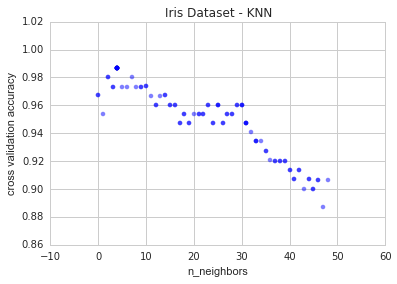

In [129]:
f, ax = plt.subplots(1)#, figsize=(10,10))
xs = [t['misc']['vals']['n_neighbors'] for t in trials.trials]
ys = [-t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_title('Iris Dataset - KNN')#, fontsize=18)
ax.set_xlabel('n_neighbors')#, fontsize=12)
ax.set_ylabel('cross validation accuracy')#, fontsize=12)
#ax.set_xlim([-1,101])
#ax.set_ylim([0, 1.01])

In [132]:
# now with scaling as an option
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

def hyperopt_train_test(params):
    X_ = X[:]
    
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X_, y).mean()
    
space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,50)),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

best = 0
def f(params):
    global best
    error = hyperopt_train_test(params)
    #print error, params
    if error > best:
        best = error
        print 'new best:', best, params
    return {'loss': -error, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print 'best:'
print best
print ''
for trial in trials.trials[-2:]:
    print trial


new best: 0.97385620915 {'n_neighbors': 3}
new best: 0.97385620915 {'n_neighbors': 11}
new best: 0.986928104575 {'n_neighbors': 5}
best:
{'normalize': 0, 'n_neighbors': 4, 'scale': 0}

{'refresh_time': None, 'book_time': None, 'misc': {'tid': 98, 'idxs': {'normalize': [98], 'n_neighbors': [98], 'scale': [98]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'normalize': [0], 'n_neighbors': [0], 'scale': [1]}, 'workdir': None}, 'state': 2, 'tid': 98, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': -0.9473039215686274}, 'owner': None, 'spec': None}
{'refresh_time': None, 'book_time': None, 'misc': {'tid': 99, 'idxs': {'normalize': [99], 'n_neighbors': [99], 'scale': [99]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'normalize': [0], 'n_neighbors': [33], 'scale': [0]}, 'workdir': None}, 'state': 2, 'tid': 99, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': -0.9342320261437909}, 'owner': None, 'spec': None}


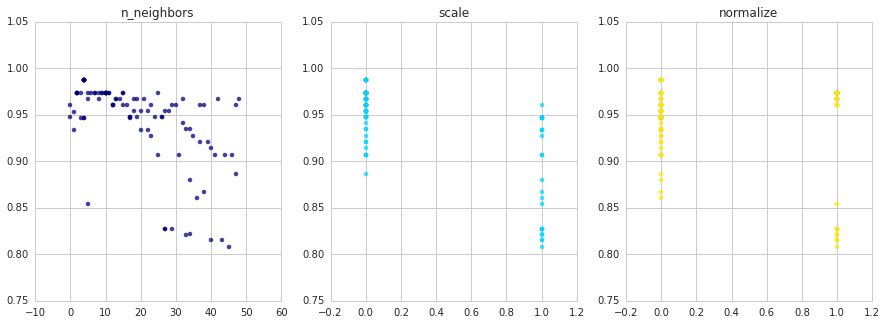

In [133]:
parameters = ['n_neighbors', 'scale', 'normalize']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)

## decision tree

In [191]:
iris = datasets.load_iris()
X_original = iris.data
y_original = iris.target

def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    clf = DecisionTreeClassifier(**params)
    return cross_val_score(clf, X, y).mean()

space4dt = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

best = 0
def f(params):
    global best
    error = hyperopt_train_test(params)
    #print error, params
    if error > best:
        best = error
        print 'new best:', best, params
    return {'loss': -error, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4dt, algo=tpe.suggest, max_evals=300, trials=trials)
print 'best:'
print best
#print ''
for trial in trials.trials[-2:]:
    print trial


new best: 0.960784313725 {'max_features': 3, 'criterion': 'gini', 'max_depth': 3}
new best: 0.966911764706 {'max_features': 2, 'criterion': 'gini', 'max_depth': 19}
new best: 0.967320261438 {'max_features': 4, 'criterion': 'gini', 'max_depth': 14}
new best: 0.97385620915 {'max_features': 2, 'criterion': 'gini', 'max_depth': 18}
best:
{'max_features': 1, 'normalize': 0, 'scale': 0, 'criterion': 0, 'max_depth': 17}
{'refresh_time': None, 'book_time': None, 'misc': {'tid': 298, 'idxs': {'max_features': [298], 'normalize': [298], 'scale': [298], 'criterion': [298], 'max_depth': [298]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'max_features': [2], 'normalize': [0], 'scale': [0], 'criterion': [1], 'max_depth': [11]}, 'workdir': None}, 'state': 2, 'tid': 298, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': -0.9673202614379085}, 'owner': None, 'spec': None}
{'refresh_time': None, 'book_time': None, 'misc': {'tid': 299, 'idxs': {'max_features': [299], 'normali

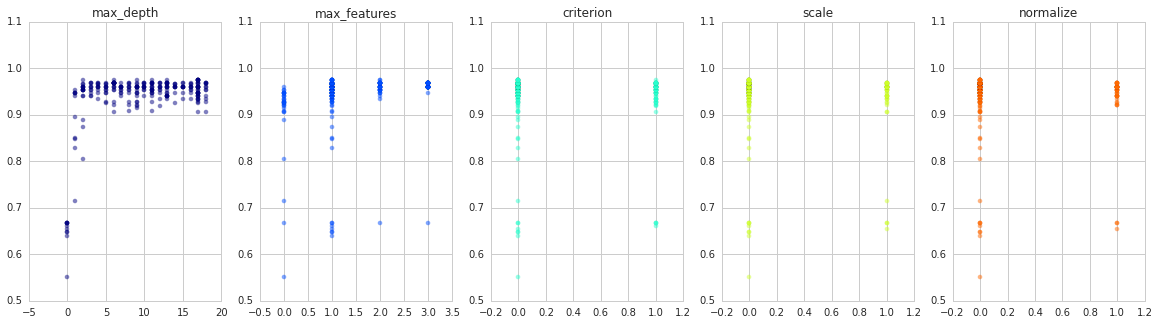

In [194]:
parameters = ['max_depth', 'max_features', 'criterion', 'scale', 'normalize'] # decision tree
#parameters = ['k', 'n_components'] # knn
#parameters = ['n_estimators', 'max_depth', 'max_features', 'criterion'] # random forest
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
    #axes[i].set_ylim([0.9,1.0])

## random forests

In [195]:
iris = datasets.load_iris()
X_original = iris.data
y_original = iris.target

def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X, y).mean()

space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'n_estimators': hp.choice('n_estimators', range(1,20)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

best = 0
def f(params):
    global best
    error = hyperopt_train_test(params)
    #print error, params
    if error > best:
        best = error
        print 'new best:', best, params
    return {'loss': -error, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=300, trials=trials)
print 'best:'
print best
#print ''
for trial in trials.trials[-2:]:
    print trial


new best: 0.894199346405 {'n_estimators': 3, 'criterion': 'gini', 'max_features': 1, 'max_depth': 3}
new best: 0.967320261438 {'n_estimators': 18, 'criterion': 'entropy', 'max_features': 4, 'max_depth': 3}
new best: 0.97385620915 {'n_estimators': 19, 'criterion': 'entropy', 'max_features': 2, 'max_depth': 16}
best:
{'normalize': 0, 'scale': 1, 'n_estimators': 18, 'criterion': 1, 'max_features': 1, 'max_depth': 15}
{'refresh_time': None, 'book_time': None, 'misc': {'tid': 298, 'idxs': {'normalize': [298], 'scale': [298], 'n_estimators': [298], 'criterion': [298], 'max_features': [298], 'max_depth': [298]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'normalize': [1], 'scale': [0], 'n_estimators': [14], 'criterion': [0], 'max_features': [2], 'max_depth': [11]}, 'workdir': None}, 'state': 2, 'tid': 298, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': -0.960375816993464}, 'owner': None, 'spec': None}
{'refresh_time': None, 'book_time': None, 'misc': {'tid': 

0 n_estimators
1 max_depth
2 max_features
3 criterion
4 scale
5 normalize


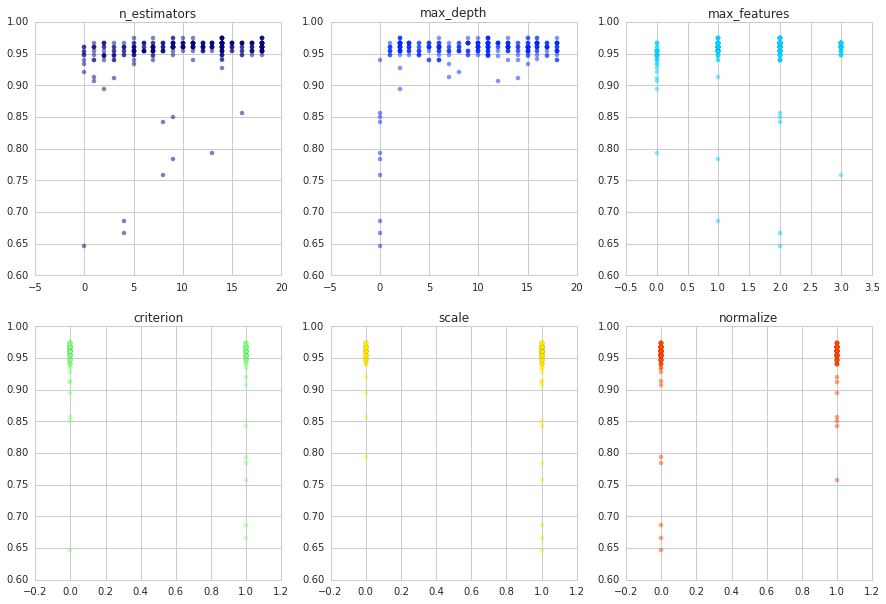

In [207]:
parameters = ['n_estimators', 'max_depth', 'max_features', 'criterion', 'scale', 'normalize']
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    print i, val
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i/3,i%3].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i/3,i%3].set_title(val)
    #axes[i/3,i%3].set_ylim([0.9,1.0])

## svm

In [175]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
#print X_original.shape, y_original.shape

def hyperopt_train_test(params):
    X_ = X[:]
    
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    
    clf = SVC(**params)
    return cross_val_score(clf, X_, y).mean()

space4svm = {
    'C': hp.uniform('C', 0, 20),
    'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
    'gamma': hp.uniform('gamma', 0, 20),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
    }

best = 0
def f(params):
    global best
    error = hyperopt_train_test(params)
    #print error, params
    if error > best:
        best = error
        print 'new best:', best, params
    return {'loss': -error, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4svm, algo=tpe.suggest, max_evals=400, trials=trials)
print 'best:'
print best
#print ''
for trial in trials.trials[-2:]:
    print trial
# best w/o pca: {'kernel': 0, 'C': 1.8609822652717964, 'gamma': 5.500323234679681}


new best: 0.954248366013 {'kernel': 'poly', 'C': 13.817697100537234, 'gamma': 8.569418523736514}
new best: 0.966911764706 {'kernel': 'sigmoid', 'C': 7.607660299777006, 'gamma': 16.95733221343286}
new best: 0.97385620915 {'kernel': 'linear', 'C': 11.650371051027797, 'gamma': 2.7011247557444684}
new best: 0.986928104575 {'kernel': 'linear', 'C': 1.712219415772422, 'gamma': 13.794413533179403}
new best: 0.993464052288 {'kernel': 'linear', 'C': 1.4168540399911616, 'gamma': 15.04230279483486}
best:
{'normalize': 0, 'kernel': 0, 'C': 1.4168540399911616, 'scale': 0, 'gamma': 15.04230279483486}
{'refresh_time': None, 'book_time': None, 'misc': {'tid': 398, 'idxs': {'normalize': [398], 'kernel': [398], 'C': [398], 'scale': [398], 'gamma': [398]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'normalize': [0], 'kernel': [2], 'C': [6.770600444926631], 'scale': [0], 'gamma': [15.575925730661465]}, 'workdir': None}, 'state': 2, 'tid': 398, 'exp_key': None, 'version': 0, 'result': {'stat

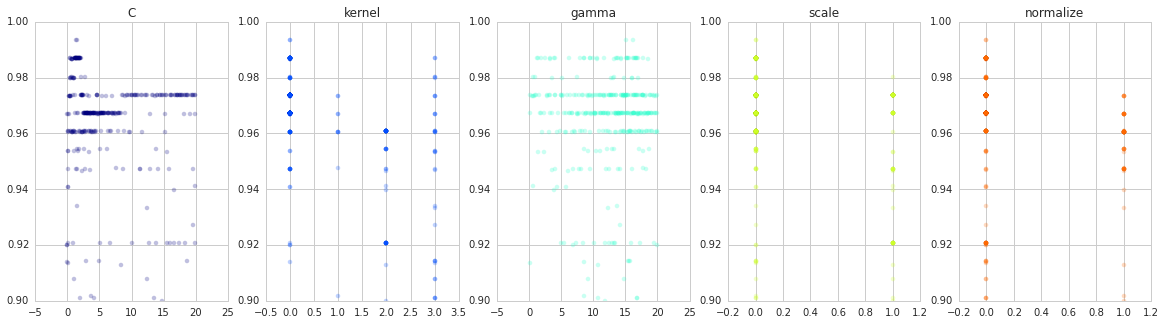

In [176]:
parameters = ['C', 'kernel', 'gamma', 'scale', 'normalize']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    #ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.25, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
    axes[i].set_ylim([0.9,1.0])

In [69]:
clf = SVC()
print 'out of the box:', cross_val_score(clf, X_original, y_original).mean()
clf = SVC(kernel='linear', C=1.8609822652717964, gamma=5.500323234679681)
print 'with hyperopt:', cross_val_score(clf, X_original, y_original).mean()

out of the box: 0.973447712418
with hyperopt: 0.993464052288


In [77]:
print X_original.shape
pca = PCA(n_components=3)
X = pca.fit_transform(X_original)
print X.shape
clf = SVC(kernel='rbf', C=7.801911541138409, gamma=3.7376757852738836)
print 'with hyperopt:', cross_val_score(clf, X, y_original).mean()

(150L, 4L)
(150L, 3L)
with hyperopt: 0.973447712418


## Digits dataset

In [39]:
digits = datasets.load_digits()
X_original = digits.data
y_original = digits.target
print X_original.shape, y_original.shape

def hyperopt_train_test(params):
    #clf = KNeighborsClassifier(n_neighbors=params['k'])
    clf = SVC(C=params['C'], kernel=params['kernel'], gamma=params['gamma'], max_iter=100)
    return cross_val_score(clf, X_original, y_original).mean()
    
space4knn = {
    'k': hp.choice('k', range(1,50)),
    'pca': hp.choice('n_components', range(1,X_original.shape[1]+1))
}

space4svm = {
    'C': hp.uniform('C', 0, 2),
    'kernel': hp.choice('kernel', ['linear', 'rbf']),# 'sigmoid', 'poly', 'rbf']),
    'gamma': hp.lognormal('gamma', 0, 1)#,
    #'pca': hp.choice('n_components', range(1,X_original.shape[1]+1))
    }

def f(params):
    error = hyperopt_train_test(params)
    #print error, params
    return {'loss': -error, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4svm, algo=tpe.suggest, max_evals=50, trials=trials)
print 'best:'
print best
#print ''
for trial in trials.trials[-2:]:
    print trial


(1797L, 64L) (1797L,)
best:
{'kernel': 1, 'C': 0.6056719060991116, 'gamma': 0.3214945076833614}
{'refresh_time': None, 'book_time': None, 'misc': {'tid': 48, 'idxs': {'kernel': [48], 'C': [48], 'gamma': [48]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'kernel': [1], 'C': [0.8590717093367628], 'gamma': [0.1041642371728071]}, 'workdir': None}, 'state': 2, 'tid': 48, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': -0.2231505221633272}, 'owner': None, 'spec': None}
{'refresh_time': None, 'book_time': None, 'misc': {'tid': 49, 'idxs': {'kernel': [49], 'C': [49], 'gamma': [49]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'kernel': [0], 'C': [0.7419009395644728], 'gamma': [0.506343572547237]}, 'workdir': None}, 'state': 2, 'tid': 49, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': -0.9443506643134789}, 'owner': None, 'spec': None}


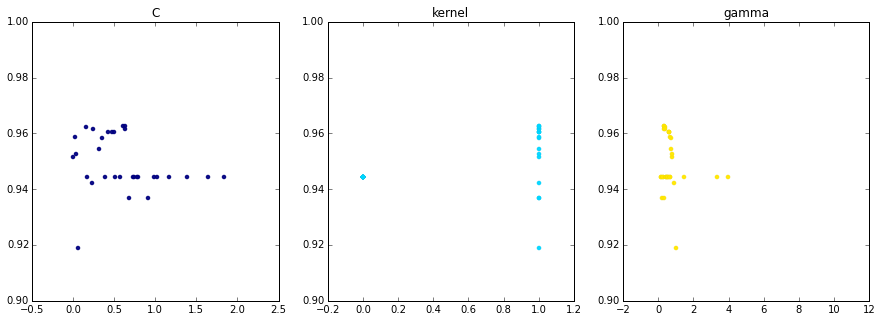

In [40]:
parameters = ['C', 'kernel', 'gamma']#, 'n_components'] # svc
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.95, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
    axes[i].set_ylim([0.9,1.0])

In [43]:
clf = SVC()
print 'out of the box:', cross_val_score(clf, X_original, y_original).mean()

clf = SVC(gamma=0.001)
print 'from sklearn page:', cross_val_score(clf, X_original, y_original).mean()

clf = SVC(gamma=0.0005)
print 'close to sklearn page:', cross_val_score(clf, X_original, y_original).mean()

clf = SVC(gamma=0.0015)
print 'close to sklearn page:', cross_val_score(clf, X_original, y_original).mean()

#nc = range(1,X_original.shape[1]+1)[30]
#pca = PCA(n_components=nc)
#X = X_original[:]#  pca.fit_transform(X_original)
#0.42057447074084037, 'gamma': 0.6188776329558462
#0.6056719060991116, 'gamma': 0.3214945076833614
clf = SVC(kernel='rbf')#, C=0.6056719060991116)#, gamma=0.3214945076833614)
print 'with hyperopt:', cross_val_score(clf, X_original, y_original).mean()

out of the box: 0.421367908463
from sklearn page: 0.97496893769
close to sklearn page: 0.971613232992
close to sklearn page: 0.971638303205
with hyperopt: 0.421367908463


In [71]:
digits = datasets.load_digits()
X_original = digits.data
y_original = digits.target
print X_original.shape, y_original.shape

def hyperopt_train_test(params):
    #print params
    t = params['type']
    del params['type']
    if t == 'naive_bayes':
        clf = BernoulliNB(**params)
    elif t == 'svm':
        kernel = params['svm_kernel']
        del params['svm_kernel']
        params['kernel'] = kernel
        if kernel == 'linear':
            clf = SVC(**params)
        elif kernel == 'rbf':
            params['width'] = params['svm_kernel']['svm_rbf_width']
            params['gamma'] = params['svm_kernel']['svm_rbf_gamma']
            clf = SVC(**params)
        else:
            clf = SVC()
    elif t == 'dtree':
        #print params
        clf = DecisionTreeClassifier(**params)
        
    elif t == 'knn':
        #print params
        clf = KNeighborsClassifier(**params)
        #print clf
    else:
        return 0
    return cross_val_score(clf, X_original, y_original).mean()
    #return cross_val_score(clf, X, y).mean()
    
space4knn = {
    'k': hp.choice('k', range(1,50)),
    'pca': hp.choice('n_components', range(1,X_original.shape[1]+1))
}

space4svm = {
    'C': hp.uniform('C', 0, 2),
    'kernel': hp.choice('kernel', ['linear', 'rbf']),# 'sigmoid', 'poly', 'rbf']),
    #,
    #'pca': hp.choice('n_components', range(1,X_original.shape[1]+1))
    }

def f(params):
    error = hyperopt_train_test(params.copy())
    print error, params['type']
    return {'loss': -error, 'status': STATUS_OK}

space = hp.choice('classifier_type', [
    {
        'type': 'naive_bayes',
        'alpha': hp.uniform('alpha', 0.0, 2.0)
    },
    {
        'type': 'svm',
        'C': hp.lognormal('svm_C', 0, 2),
        'svm_kernel': hp.choice('svm_kernel_type', [
            {'kernel': 'linear'},
            {'kernel': 'rbf', 
                'width': hp.lognormal('svm_rbf_width', 0, 1.0),
                'gamma': hp.lognormal('svm_rbf_gamma', 0, 1.0)
            },
        ]),
    },
    {
        'type': 'dtree',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', range(1,20)),
        'min_samples_split': hp.qlognormal('dtree_min_samples_split', 2, 1, 1),
    },
    {
        'type': 'knn',
        'n_neighbors': hp.choice('knn_n_neighbors', range(1,50))
    }
])

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=50, trials=trials)
print 'best:'
print best
#print ''
#for trial in trials.trials[-3:]:
#    print trial['misc']['vals']['classifier_type']


(1797L, 64L) (1797L,)
0.449114131854 dtree
0.745126222905 dtree
0.421367908463 svm
0.771339803892 dtree
0.421367908463 svm
0.779617747939 dtree
0.927658862913 knn
0.421367908463 svm
0.934887679679 knn
0.421367908463 svm
0.421367908463 svm
0.928771856886 knn
0.937672923822 knn
0.926545868941 knn
0.780201962678 dtree
0.527009174035 dtree
0.828620043442 naive_bayes
0.828620043442 naive_bayes
0.449114131854 dtree
0.421367908463 svm
0.937672923822 knn
0.937672923822 knn
0.937672923822 knn
0.963841882809 knn
0.963841882809 knn
0.820804127094 naive_bayes
0.929325566742 knn
0.963841882809 knn
0.963841882809 knn
0.932094088104 knn
0.820804127094 naive_bayes
0.956067759455 knn
0.934882133336 knn
0.923206914942 knn
0.824151400607 naive_bayes
0.963841882809 knn
0.75234946541 dtree
0.421367908463 svm
0.929325566742 knn
0.946599033053 knn
0.421367908463 svm
0.75401322856 dtree
0.921540211113 knn
0.824151400607 naive_bayes
0.964403968015 knn
0.421367908463 svm
0.769653520358 dtree
0.922655978257 knn


In [49]:
for trial in trials.trials[-1:]:
    print trial['misc']['vals']['classifier_type']


[1]


0 knn_n_neighbors
1 type


KeyError: 'type'

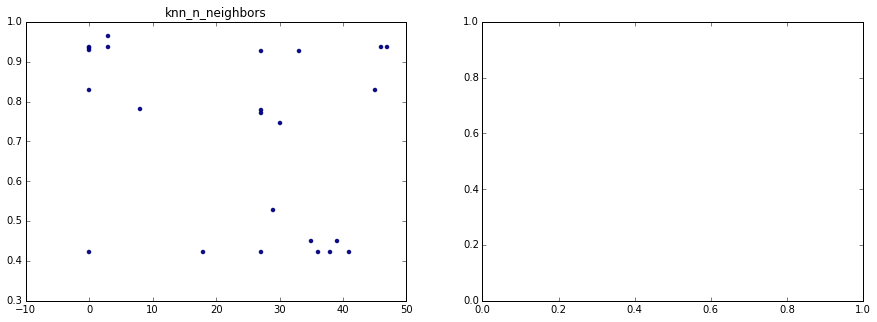

In [72]:
parameters = ['C', 'kernel', 'gamma']#, 'n_components'] # svc
parameters = ['knn_n_neighbors', 'type']
#parameters = ['dtree_criterion', 'dtree_max_depth', 'dtree_min_samples_split']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,5))
cmap = plt.cm.jet
#good_trials = trials.trials

for i, val in enumerate(parameters):
    print i, val
    xs = np.array([t['misc']['vals'][val] for t in trials.trials if t['misc']['vals']['classifier_type']==[3]]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.95, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
    #axes[i].set_ylim([0.9,1.0])